Mount the drive - only for google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make the current working directory the drive folder

In [ ]:
import os
folder_path = '/content/drive/My Drive/Samsung_Prism'
os.chdir(folder_path)

Import Everything - All the libraries

In [ ]:
import re
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from keras import layers

In [ ]:
# # Dataset size = 1246
# IMAGE_SIZE = 256
# BATCH_SIZE = 32 #We are keeping 32 images in each batch.
# MAX_TRAIN_IMAGES = 1152 #37 batches for Training.
# # maybe we can use cross validation

Sort the Low Light Images

In [ ]:
# extraVal = 2
# train_low_light_images = sorted(glob("./All Datasets/Dark And Bright Dataset/dark/*"),
#                                 key=lambda x: int(re.search(r'\d+', x).group()))[:MAX_TRAIN_IMAGES]
# val_low_light_images = sorted(glob("./All Datasets/Dark And Bright Dataset/dark/*"),
#                                 key=lambda x: int(re.search(r'\d+', x).group()))[MAX_TRAIN_IMAGES:MAX_TRAIN_IMAGES + (BATCH_SIZE * extraVal)] #64 for validation
# test_low_light_images = sorted(glob("./All Datasets/Dark And Bright Dataset/dark/*"),
#                                 key=lambda x: int(re.search(r'\d+', x).group()))[MAX_TRAIN_IMAGES + (BATCH_SIZE * extraVal):] #30 images for testing

Yeah so to add an extra image, just add an extra integer here in the test_low_light_images. So that only your image is outputed in the end part. Understood?

In [ ]:
# def loadData(imagePath):
#     image = tf.io.read_file(imagePath)
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = tf.image.resize(images = image, size = [IMAGE_SIZE, IMAGE_SIZE])
#     image = image / 255.0
#     return image

# def dataGenerator(low_light_images):
#     dataset = tf.data.Dataset.from_tensor_slices((low_light_images))
#     dataset = dataset.map(loadData, num_parallel_calls=tf.data.AUTOTUNE)
#     dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)
#     return dataset

In [ ]:
# train_dataset = dataGenerator(train_low_light_images)
# val_dataset = dataGenerator(val_low_light_images)

# print(f"Train Dataset: {train_dataset}")
# print(f"Validation Dataset: {val_dataset}")

Train Dataset: <_BatchDataset element_spec=TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None)>
Validation Dataset: <_BatchDataset element_spec=TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None)>


In [ ]:
def buildingOurNeuralNetwork():
    """Six Convolutional 2D Layers, 3 Concatenation Layers and 1 Finalizing Convolutional layer with 24 filters"""
    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(32, (3,3), strides = (1,1), activation="relu", padding="same")(input_img)
    conv2 = layers.Conv2D(32, (3,3), strides = (1,1), activation="relu", padding="same")(conv1)
    conv3 = layers.Conv2D(32, (3,3), strides = (1,1), activation="relu", padding="same")(conv2)
    conv4 = layers.Conv2D(32, (3,3), strides = (1,1), activation="relu", padding="same")(conv3)
    int_conv1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(32, (3,3), strides = (1,1), activation="relu", padding="same")(int_conv1)
    int_conv2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(32, (3,3), strides = (1,1), activation="relu", padding="same")(int_conv2)
    int_conv3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3,3), strides=(1,1), activation="tanh", padding="same")(int_conv3)

    return keras.Model(inputs = input_img, outputs= x_r)

Creating 4 Different Type of Losses to make sure the model is more efficient. Doing this to prevent errors in relation to image lighting and colors.

Color Loss Function

In [ ]:
def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1,2), keepdims=True)
    mr, mg, mb = mean_rgb[:, :, :, 0], mean_rgb[:, :, :, 1], mean_rgb[:, :, :, 2]
    rg = tf.square(mr - mg)
    rb = tf.square(mr - mb)
    gb = tf.square(mb - mg)
    return tf.sqrt(tf.square(rg) + tf.square(rb) + tf.square(gb))

Exposure Loss: gives average intensity value of a local region and a preset well-exposedness level (set to 0.6)

In [ ]:
def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))

Illumination Smoothness Loss: To preserve monotonicity relation between neighboughring pixels

In [ ]:
def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    height_x = tf.shape(x)[1]
    weight_x = tf.shape(x)[2]
    count_h = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    count_w = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    reduced_height_x = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : height_x - 1, :, :])))
    reduced_width_x = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : weight_x - 1, :])))
    batch_size = tf.cast(batch_size, dtype = tf.float32)
    count_h = tf.cast(count_h, dtype=tf.float32)
    count_w = tf.cast(count_w, dtype=tf.float32)
    return 2 * (reduced_height_x / count_h + reduced_width_x / count_w) / batch_size


Spatial Consistency Loss: Done to keep the image looking the same even after the model goes through it. So that parts of the output-image should not be bigger/smaller than the original image.

In [ ]:
class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super(SpatialConsistencyLoss, self).__init__(reduction="none")

        self.left_kernel = tf.constant([[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype= tf.float32)
        self.right_kernel = tf.constant([[[[0, 0, 0]], [[0,1, -1]], [[0, 0, 0]]]], dtype= tf.float32)
        self.up_kernel = tf.constant([[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype= tf.float32)
        self.down_kernel = tf.constant([[[[0, 0, 0]], [[-1, 1, 0]], [[0, -1, 0]]]], dtype= tf.float32)

    def call(self, y_true, y_pred):
        original_mean = tf.reduce_mean(y_true, 3, keepdims = True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims = True)
        original_pool = tf.nn.avg_pool2d(original_mean, ksize= 4, strides = 4, padding="VALID")
        enhanced_pool = tf.nn.avg_pool2d(enhanced_mean, ksize= 4, strides = 4, padding="VALID")
        d_original_left = tf.nn.conv2d(original_pool, self.left_kernel, strides = [1, 1, 1, 1], padding="SAME")
        d_original_right = tf.nn.conv2d(original_pool, self.right_kernel, strides = [1, 1, 1, 1], padding="SAME")
        d_original_up = tf.nn.conv2d(original_pool, self.up_kernel, strides = [1, 1, 1, 1], padding="SAME")
        d_original_down = tf.nn.conv2d(original_pool, self.down_kernel, strides = [1, 1, 1, 1], padding="SAME")
        d_enhanced_left = tf.nn.conv2d(enhanced_pool, self.left_kernel, strides = [1, 1, 1, 1], padding="SAME")
        d_enhanced_right = tf.nn.conv2d(enhanced_pool, self.right_kernel, strides = [1, 1, 1, 1], padding="SAME")
        d_enhanced_up = tf.nn.conv2d(enhanced_pool, self.up_kernel, strides = [1, 1, 1, 1], padding="SAME")
        d_enhanced_down = tf.nn.conv2d(enhanced_pool, self.down_kernel, strides = [1, 1, 1, 1], padding="SAME")

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)

        return d_left + d_right + d_up + d_down

Deep Curve Estimation Model: Here we implement the zero-dce framework of Keras

In [ ]:
class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super(ZeroDCE, self).__init__(**kwargs)
        self.model = buildingOurNeuralNetwork()

    def compile(self, learning_rate, **kwargs):
        super(ZeroDCE, self).compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")

    def get_enhanced_image(self, data, output):
        #multi stage non linear enhancement process
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]

        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)

        enhanced_image = x + r4 * (tf.square(x) - x)

        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)

        enhanced_image = x + r8 * (tf.square(x) - x)

        return enhanced_image

    def call(self, data):
        dce_net_output = self.model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination +
            loss_spatial_constancy +
            loss_color_constancy +
            loss_exposure
        )
        return {
            "total_loss" : total_loss,
            "illumination_smoothness_loss" : loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss" : loss_color_constancy,
            "exposure_loss" : loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.model(data)
            losses = self.compute_losses(data, output)
        gradients = tape.gradient(
            losses["total_loss"], self.model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.model(data)
        return self.compute_losses(data, output)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        self.model.save_weights(
            filepath, overwrite = overwrite, save_format = save_format, options = options
        )

    def load_weights(self, filepath, by_name = False, skip_mismatch=False, options=None):
        self.model.load_weights(
            filepath = filepath,
            by_name = by_name,
            skip_mismatch = skip_mismatch,
            options = options
        )

Training

Using K-Folds

In [ ]:
#  #Code only for cross validation, not utilized yet.
#  # Define plot_result function
# def plot_result(history, item, fold):
#     plt.plot(history.history[item], label=fold)
#     plt.plot(history.history["val_" + item], label="val_" + str(fold))
#     plt.xlabel("Epochs")
#     plt.ylabel(item)
#     plt.title(f"Train and Validation {item} Over Epochs (Fold {fold})")
#     plt.legend()
#     plt.grid()
#     plt.show()

# # Define ourModel
# ourModel = ZeroDCE()
# ourModel.compile(learning_rate=1e-4)

# #convert the dataset into a np array
# #file_paths = [os.path.join(train_dataset, filename) for filename in range(MAX_TRAIN_IMAGES)]
# #data = np.array(file_paths)

# # Define KFold parameters
# data = np.array(list(train_dataset.as_numpy_iterator()))  # Assuming train_dataset is iterable
# num_folds = 6 # multiple of 1152, so 192 images in each fold
# kf = KFold(n_splits=num_folds)

# # Store history for each fold
# fold_histories = []

# # Iterate over folds

# #for fold, (train_index, val_index) in enumerate(kf.split(data)):
#     # print(f"Training on fold {fold + 1}/{num_folds}...")

# # for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):
# for fold, (bigThing) in enumerate(kf.split(train_dataset)):
#     print(f"Training on fold {fold + 1}/{num_folds}...")

#     # Use train_index and val_index to access the data for training and validation
#     # train_fold, val_fold = data[train_index], data[val_index]

#     # Prepare data for this fold
#     train_fold, val_fold  = train_dataset[train_index], train_dataset[val_index]

#     # Train the model on this fold
#     history = ourModel.fit(train_fold, validation_data=val_fold, epochs=100)
#     # history = ourModel.fit(train_fold, validation_data=(val_fold, val_labels), epochs=100)


#     # Store the history for this fold
#     fold_histories.append(history)

#     # Plot results for this fold
#     for item in ["total_loss", "illumination_smoothness_loss", "spatial_constancy_loss", "color_constancy_loss", "exposure_loss"]: plot_result(history, item, fold)




TypeError: Singleton array array(<_BatchDataset element_spec=TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None)>,
      dtype=object) cannot be considered a valid collection.

In [ ]:
# Convert the filenames to their corresponding file paths
folder_path = '/content/drive/My Drive/Samsung_Prism/All Datasets/Dark And Bright Dataset/dark/'
file_paths = [os.path.join(folder_path, f"{filename}.jpg") for filename in range(1, 833)]
for filename in range (833, 1216):
  file_paths.append(os.path.join(folder_path, f"{filename}.png"))
for filename in range (1233, 1254):
  file_paths.append(os.path.join(folder_path, f"{filename}.png"))

# Convert the list of file paths to a numpy array
data = np.array(file_paths)

# Define KFold parameters
num_folds = 4
kf = KFold(n_splits=num_folds)

# Define a function to load and preprocess images
def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Define a function to create a TensorFlow dataset from a list of file paths
def create_tf_dataset(file_paths):
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# Iterate over folds
fold_histories = []
for fold, (train_index, val_index) in enumerate(kf.split(data)):
    print(f"Training on fold {fold + 1}/{num_folds}...")

    # Split the data into training and validation sets
    train_files = data[train_index]
    val_files = data[val_index]

    # Create TensorFlow datasets for training and validation
    train_dataset = create_tf_dataset(train_files)
    val_dataset = create_tf_dataset(val_files)

    ourModel = ZeroDCE()
    ourModel.compile(
        learning_rate = 1e-4
        )

    # Train the model
    history = ourModel.fit(train_dataset, validation_data=val_dataset, epochs=100)
    fold_histories.append(history)

# After training, you can evaluate the model on the test set if needed
# test_dataset = create_tf_dataset(test_files)

# Define plot_result function
def plot_result(history, item, fold):
    plt.plot(history.history[item], label=f'Train {item} Fold {fold}')
    plt.plot(history.history["val_" + item], label=f'Validation {item} Fold {fold}')
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title(f"Train and Validation {item} Over Epochs (Fold {fold})")
    plt.legend()
    plt.grid()
    plt.show()

# Plot results for each fold
for fold, history in enumerate(fold_histories):
    for item in ["total_loss", "illumination_smoothness_loss", "spatial_constancy_loss", "color_constancy_loss", "exposure_loss"]:  # Replace with your specific metrics
        plot_result(history, item, fold + 1)


Training on fold 1/4...
Epoch 1/100
29/29 [==============================] - 43s 1s/step - total_loss: 39.0248 - illumination_smoothness_loss: 36.4180 - spatial_constancy_loss: 3.8135e-04 - color_constancy_loss: 0.0264 - exposure_loss: 2.5800 - val_total_loss: 49.4489 - val_illumination_smoothness_loss: 46.8524 - val_spatial_constancy_loss: 2.1460e-04 - val_color_constancy_loss: 0.0293 - val_exposure_loss: 2.5670
Epoch 2/100
29/29 [==============================] - 36s 1s/step - total_loss: 26.8055 - illumination_smoothness_loss: 24.2316 - spatial_constancy_loss: 1.5054e-04 - color_constancy_loss: 0.0167 - exposure_loss: 2.5571 - val_total_loss: 35.6204 - val_illumination_smoothness_loss: 33.0468 - val_spatial_constancy_loss: 6.5985e-05 - val_color_constancy_loss: 0.0252 - val_exposure_loss: 2.5484
Epoch 3/100
29/29 [==============================] - 36s 1s/step - total_loss: 19.8089 - illumination_smoothness_loss: 17.2584 - spatial_constancy_loss: 4.1652e-05 - color_constancy_loss: 0.

KeyboardInterrupt: 

Using Normal Method, no KFolds

Epoch 1/100
36/36 [==============================] - 102s 2s/step - total_loss: 36.6423 - illumination_smoothness_loss: 34.2118 - spatial_constancy_loss: 1.1964e-04 - color_constancy_loss: 0.0349 - exposure_loss: 2.3955 - val_total_loss: 13.1802 - val_illumination_smoothness_loss: 9.8019 - val_spatial_constancy_loss: 6.7381e-06 - val_color_constancy_loss: 3.3030e-04 - val_exposure_loss: 3.3779
Epoch 2/100
36/36 [==============================] - 39s 1s/step - total_loss: 23.5431 - illumination_smoothness_loss: 21.1212 - spatial_constancy_loss: 1.3172e-04 - color_constancy_loss: 0.0322 - exposure_loss: 2.3896 - val_total_loss: 9.7249 - val_illumination_smoothness_loss: 6.3490 - val_spatial_constancy_loss: 8.7355e-06 - val_color_constancy_loss: 2.9380e-04 - val_exposure_loss: 3.3755
Epoch 3/100
36/36 [==============================] - 40s 1s/step - total_loss: 16.4090 - illumination_smoothness_loss: 13.9988 - spatial_constancy_loss: 1.7593e-04 - color_constancy_loss: 0.0309 - exposure_lo

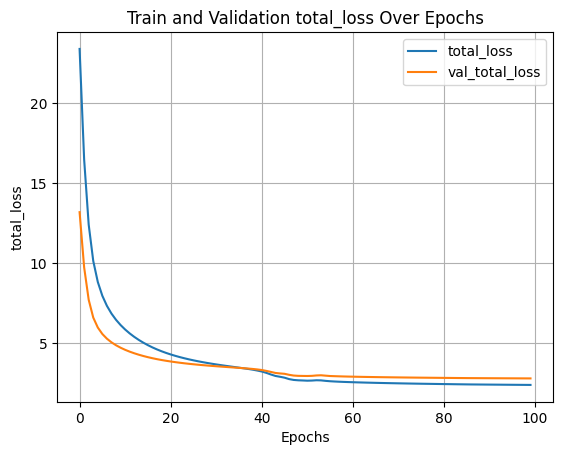

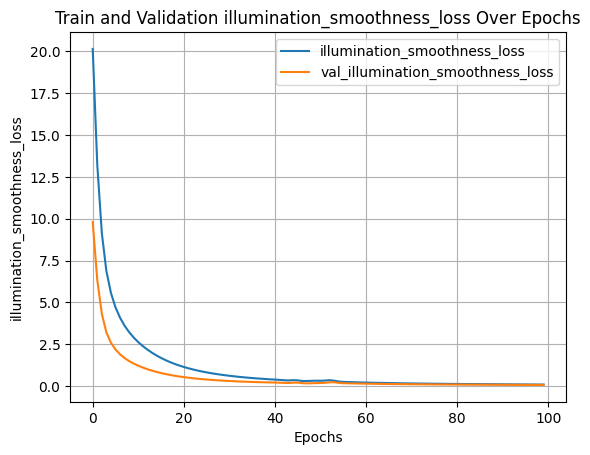

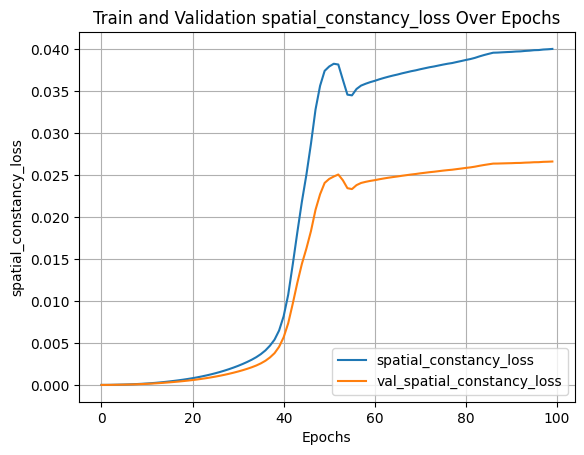

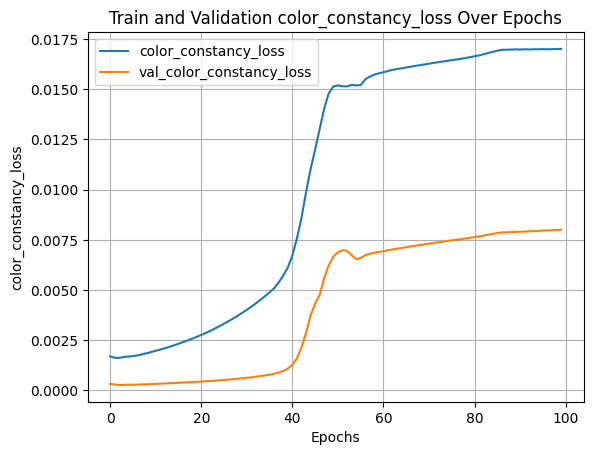

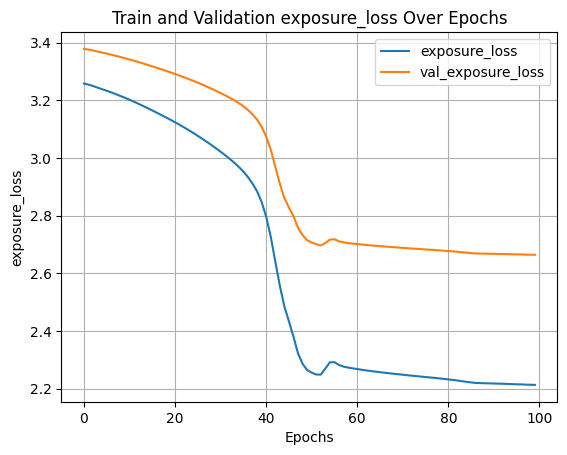

In [ ]:
ourModel = ZeroDCE()
ourModel.compile(learning_rate = 1e-4)
history = ourModel.fit(train_dataset, validation_data = val_dataset, epochs = 100)


def plot_result(item):
    plt.plot(history.history[item], label = item)
    plt.plot(history.history["val_" + item], label = "val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title(f"Train and Validation {item} Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")

Inference that we are getting, i.e, the final product

In [ ]:
# loaded_model = ZeroDCE()

# # Load the weights into the model
# loaded_model.load_weights("C:\\mycode\\python\\Samsung Prism\\image_clarifyer_model1.h5")


def plot_results(images, titles, figure_size = (12, 12)):
    fig = plt.figure(figsize = figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i+1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

def infer(original_image):
    image = keras.preprocessing.image.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis = 0)
    output_image = ourModel(image) #use this when actually running the code
    output_image = ourModel(image) #use when training the actual model
    # output_image = loaded_model(image) #commented for when running the saved-weight model
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

Inference on Test Images: This is where we compare the test images with the output they are supposed to have.

In [ ]:
test_bright_light_images = sorted(glob("./All Datasets/Dark And Bright Dataset/bright/*"),
                                key=lambda x: int(re.search(r'\d+', x).group()))[:]
for val_image_file, ref_image_file in zip(test_low_light_images, test_bright_light_images):
    original_image = Image.open(val_image_file)
    ref_image = Image.open(ref_image_file)
    enhanced_image = infer(original_image)
    plot_results(
        # [original_image, ImageOps.autoconstrast(original_image), enhanced_image],
        [original_image, ref_image, enhanced_image],
        ["original", "Expected Output", "Enhanced"],
        (20, 12,),
    )

NameError: name 'glob' is not defined

Save the Model

In [ ]:
ourModel.save_weights("./image_clarifyer_model2.h5")